In this question, you will implement a **vision transformer** based image classification model using pytorch.
a)Implement a basic version of **vision transformer(https://arxiv.org/pdf/2010.11929.pdf)**, that first divides an image into **patches** and then passes them through a set of **multihead self attention** modules to perform classification.

In [23]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.0+cu117
torchvision version: 0.15.1+cu117


In [24]:

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary



In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# DATA LOADING

In [26]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader

In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# preparing transforms and dataloader for images

In [28]:

#Hyper parameter
LEARNING_RATE=10**(-4)
BATCH_SIZE = 100 
IMG_SIZE = 32
PATCH_SIZE=4
IN_CHANNELS=3
EMBEDDING_DIMENTION=PATCH_SIZE*PATCH_SIZE*IN_CHANNELS*5
NUM_HEADS=12
NUM_ATTENTION_LAYERS=4
DROPOUT_P=0.1
MLP_SIZE=1024
NUM_LABELS=10


In [29]:



manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")


#imgdata contains transformed images
train_dataset = CIFAR10(root='imgdata/', download=True, transform=manual_transforms)
test_dataset = CIFAR10(root='imgdata/', train=False, transform=manual_transforms)


train_dataloader = DataLoader(
      train_dataset,
      batch_size=BATCH_SIZE,
      shuffle=False,
      pin_memory=True,
  )
test_dataloader = DataLoader(
      test_dataset,
      batch_size=BATCH_SIZE,
      shuffle=False,
      pin_memory=True,
  )

train_dataloader, test_dataloader

Manually created transforms: Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)
Files already downloaded and verified


(<torch.utils.data.dataloader.DataLoader at 0x7f4838181100>,
 <torch.utils.data.dataloader.DataLoader at 0x7f4838181280>)

torch.Size([100, 3, 32, 32]) torch.Size([100])


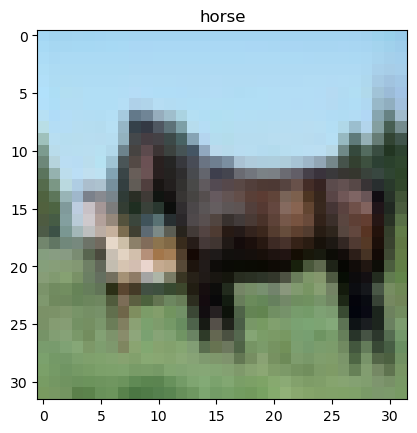

In [30]:
# Get a batch of images


image_batch, label_batch = next(iter(train_dataloader))
print(image_batch.shape,label_batch.shape)
# Get a single image from the batch
image, label = image_batch[12], label_batch[12]
plt.imshow(image.permute(1,2,0))
plt.title(train_dataset.classes[label])
plt.show()

# Patch embedding

In [31]:
class Patch_embedding(nn.Module):
    
    
    def __init__(self,
                 in_channels=3,
                 patch_size=8,
                 embedding_dim=768
                ):
        
        super().__init__()
        self.patcher=nn.Conv2d(in_channels=in_channels,
                               out_channels=embedding_dim,
                               kernel_size=patch_size,
                               stride=patch_size,
                               padding=0
                              )
        
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
    def forward(self,x):
        image_resolution = x.shape[-1]
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        return x_flattened.permute(0, 2, 1)
        


In [32]:



patchify=Patch_embedding(in_channels=IN_CHANNELS,
                 patch_size=PATCH_SIZE,
                 embedding_dim=EMBEDDING_DIMENTION)



print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) 
print(f"Output patch embedding shape: {patch_embedded_image.shape}")



Input image shape: torch.Size([1, 3, 32, 32])
Output patch embedding shape: torch.Size([1, 64, 240])


In [33]:
summary(Patch_embedding())

Layer (type:depth-idx)                   Param #
Patch_embedding                          --
├─Conv2d: 1-1                            148,224
├─Flatten: 1-2                           --
Total params: 148,224
Trainable params: 148,224
Non-trainable params: 0

## including class token

In [34]:
class_token= nn.Parameter(torch.ones((1,1,EMBEDDING_DIMENTION)),requires_grad=True) #1 can be replaced with BATCH_SIZE
class_token.shape

torch.Size([1, 1, 240])

In [35]:
final_embedding=torch.cat((class_token,patch_embedded_image),dim=1)
final_embedding.shape

torch.Size([1, 65, 240])

# MSA LAYER

In [36]:

class MultiheadSelfAttentionBlock(nn.Module):
    
    def __init__(self,
                 embedding_dim =EMBEDDING_DIMENTION, 
                 num_heads=NUM_HEADS, 
                 attn_dropout=0):
        super().__init__()
        
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) 
        
    
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x, 
                                             value=x, 
                                             need_weights=False)
        return attn_output

In [37]:
Multihead=MultiheadSelfAttentionBlock()
print(final_embedding.shape)
after_msa_out=Multihead(final_embedding)
print(after_msa_out.shape)


torch.Size([1, 65, 240])
torch.Size([1, 65, 240])


# MLP layer in encoder

In [38]:

class MLPBlock(nn.Module):
    
    def __init__(self,
                 embedding_dim=EMBEDDING_DIMENTION, 
                 mlp_size = MLP_SIZE, 
                 dropout = DROPOUT_P): 
        super().__init__()
        
      
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
       
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), 
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, 
                      out_features=embedding_dim), 
            nn.Dropout(p=dropout) 
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [39]:
MLP=MLPBlock()
print(after_msa_out.shape)
after_mlp_out=MLP(after_msa_out)
print(after_mlp_out.shape)


torch.Size([1, 65, 240])
torch.Size([1, 65, 240])


# ENCODER BLOCK

In [40]:
class EncoderBlock(nn.Module):
   
    def __init__(self,
                 embedding_dim=EMBEDDING_DIMENTION, 
                 num_heads=NUM_HEADS, 
                 mlp_size=MLP_SIZE, 
                 mlp_dropout=DROPOUT_P, 
                 attn_dropout=0): 
        super().__init__()

        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
 
    def forward(self, x):
        
        
        x =  self.msa_block(x) + x 
        
        
        x = self.mlp_block(x) + x 
        
        return x

# ViT 

In [41]:

class ViT(nn.Module):
    
    def __init__(self,
                 img_size=IMG_SIZE, 
                 in_channels=IN_CHANNELS, 
                 patch_size=PATCH_SIZE, 
                 num_transformer_layers=NUM_ATTENTION_LAYERS, 
                 embedding_dim=EMBEDDING_DIMENTION, 
                 mlp_size=MLP_SIZE, 
                 num_heads=NUM_HEADS, 
                 attn_dropout=0, 
                 mlp_dropout=DROPOUT_P, 
                 embedding_dropout=DROPOUT_P, # Dropout for patch and position embeddings
                 num_classes=NUM_LABELS): 
        
        super().__init__() 
        
        
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
       
        self.patch_embedding = Patch_embedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        
        self.transformer_encoder = nn.Sequential(*[EncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
        
    
    def forward(self, x):
        
        batch_size = BATCH_SIZE
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) 
        
        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0]) 

        return x       

In [42]:
from tqdm import tqdm

def train(model,
          train_dataloader,
          test_dataloader,
          max_epochs,
          device,
         ):
    
    
    optimiser=torch.optim.Adam(params=model.parameters(), 
                             lr=10**(-4))
#                              betas=(0.9, 0.999), 
#                              weight_decay=0.3) 
    loss_fn=nn.CrossEntropyLoss()
    
    
    model.to(device)
    
    loss_curve=[]
    train_acc_curve=[]
    test_acc_curve=[]
    
    for epoch in tqdm(range(max_epochs)):
        model.train()
        train_loss=0
        train_accuracy=0
        test_acc=0
        
        for batch_id,(X,y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred=model(X)
            #print(y_pred.shape,y.shape,y_pred,y)
            loss=loss_fn(y_pred,y)
            
            train_loss+=loss.item()
            
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            
            y_pred=torch.argmax(y_pred,dim=1)
            #print(y_pred.shape)
            batch_correct=((y_pred==y).sum().item())/BATCH_SIZE
            train_accuracy+=batch_correct
           # print(loss.item(),batch_correct)
        


        for batch_id,(X,y) in enumerate(test_dataloader):
                  
            X, y = X.to(device), y.to(device)
            y_pred=model(X)


            y_pred=torch.argmax(y_pred,dim=1)

            batch_correct=((y_pred==y).sum().item())/BATCH_SIZE
            test_acc+=batch_correct
          
            
            
        loss_curve.append(train_loss/len(train_dataloader))
        train_acc_curve.append(train_accuracy/len(train_dataloader))
        test_acc_curve.append(test_acc/len(test_dataloader))
        
        print(f"epoch:{epoch+1} train_loss:{loss_curve[-1]} train_acc:{train_acc_curve[-1]} test_acc:{test_acc_curve[-1]}")
             
    return loss_curve[-1],train_acc_curve[-1],test_acc_curve[-1]
        
            
        

In [43]:
summary(ViT())

Layer (type:depth-idx)                                            Param #
ViT                                                               15,840
├─Dropout: 1-1                                                    --
├─Patch_embedding: 1-2                                            --
│    └─Conv2d: 2-1                                                11,760
│    └─Flatten: 2-2                                               --
├─Sequential: 1-3                                                 --
│    └─EncoderBlock: 2-3                                          --
│    │    └─MultiheadSelfAttentionBlock: 3-1                      231,840
│    │    └─MLPBlock: 3-2                                         493,264
│    └─EncoderBlock: 2-4                                          --
│    │    └─MultiheadSelfAttentionBlock: 3-3                      231,840
│    │    └─MLPBlock: 3-4                                         493,264
│    └─EncoderBlock: 2-5                                          --
│

## Patch_Size_Experiment

In [ ]:
Patches=[2,4,8,16,32]
loss_per_patch=[]
train_acc_per_patch=[]
test_acc_per_patch=[]
for i in range(5):
    PATCH_SIZE = Patches[i]
    print(f"Patch Size = {PATCH_SIZE}")
    vit=ViT()
    loss,train_accuracy,test_accuracy=train(model=vit,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      device=device,
      max_epochs=10,
      )
    train_acc_per_patch.append(train_accuracy)
    test_acc_per_patch.append(test_accuracy)
    loss_per_patch.append(loss)

Patch Size = 2


 10%|████▎                                      | 1/10 [01:50<16:38, 110.93s/it]

epoch:1 train_loss:1.9844052996635437 train_acc:0.26818000000000014 test_acc:0.35700000000000004


 20%|████████▌                                  | 2/10 [03:50<15:26, 115.77s/it]

epoch:2 train_loss:1.7382736122608184 train_acc:0.37383999999999984 test_acc:0.40840000000000004


 30%|████████████▉                              | 3/10 [05:45<13:28, 115.46s/it]

epoch:3 train_loss:1.6128592882156372 train_acc:0.42121999999999976 test_acc:0.4414000000000001


 40%|█████████████████▏                         | 4/10 [07:45<11:44, 117.45s/it]

epoch:4 train_loss:1.5281915171146392 train_acc:0.45112000000000035 test_acc:0.46329999999999993


 50%|█████████████████████▌                     | 5/10 [09:48<09:57, 119.48s/it]

epoch:5 train_loss:1.4615172436237336 train_acc:0.4743599999999998 test_acc:0.47619999999999985


 60%|█████████████████████████▊                 | 6/10 [11:49<07:59, 119.93s/it]

epoch:6 train_loss:1.4148858723640443 train_acc:0.49083999999999994 test_acc:0.49110000000000015


 70%|██████████████████████████████             | 7/10 [13:50<06:00, 120.26s/it]

epoch:7 train_loss:1.3694533975124359 train_acc:0.5062600000000003 test_acc:0.5086000000000002


 80%|██████████████████████████████████▍        | 8/10 [15:50<04:00, 120.26s/it]

epoch:8 train_loss:1.3340743072032928 train_acc:0.5186000000000004 test_acc:0.5132000000000001


 90%|██████████████████████████████████████▋    | 9/10 [17:51<02:00, 120.52s/it]

epoch:9 train_loss:1.2979206187725068 train_acc:0.5321800000000007 test_acc:0.5296000000000002


100%|██████████████████████████████████████████| 10/10 [19:51<00:00, 119.18s/it]


epoch:10 train_loss:1.264866498351097 train_acc:0.5466400000000008 test_acc:0.5345000000000002
Patch Size = 4


 10%|████▎                                      | 1/10 [02:03<18:28, 123.17s/it]

epoch:1 train_loss:1.9975338139533996 train_acc:0.25967999999999974 test_acc:0.35279999999999995


 20%|████████▌                                  | 2/10 [04:05<16:21, 122.75s/it]

epoch:2 train_loss:1.7329924674034118 train_acc:0.37739999999999996 test_acc:0.4050000000000001


 30%|████████████▉                              | 3/10 [06:05<14:10, 121.49s/it]

epoch:3 train_loss:1.6217646906375884 train_acc:0.41817999999999955 test_acc:0.43690000000000007


 40%|█████████████████▏                         | 4/10 [08:04<12:03, 120.57s/it]

epoch:4 train_loss:1.5385855824947356 train_acc:0.4496599999999997 test_acc:0.4603999999999999


 50%|█████████████████████▌                     | 5/10 [10:06<10:04, 120.95s/it]

epoch:5 train_loss:1.4784809691905976 train_acc:0.46865999999999963 test_acc:0.47729999999999984


 60%|█████████████████████████▊                 | 6/10 [12:10<08:08, 122.10s/it]

epoch:6 train_loss:1.4258230352401733 train_acc:0.4889399999999995 test_acc:0.48540000000000005


In [ ]:
# print(train_acc_per_patch)
# print(test_acc_per_patch)
# #plt.plot()
# plt.figure(figsize=(15,6))

# plt.plot(Patches,train_acc_per_patch,label="accuracy")
# #plt.plot(Patches,test_acc_per_patch,label="accuracy")
# plt.xlabel("PATCHES")
# plt.ylabel("accuracy")

In [ ]:

#plt.plot()
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(Patches,train_acc_per_patch,label="train-accuracy")
plt.plot(Patches,test_acc_per_patch,label="test-accuracy")
plt.ylim(0,1)
plt.xlabel("PATCHES")
plt.ylabel("accuracy")

## ATTENTION HEADS EXPERIMENT

In [ ]:
Attention_Heads=[4,8,12,16]
loss_per_patch=[]
train_acc_per_patch=[]
test_acc_per_patch=[]
for i in range(4):
    NUM_HEADS = Attention_Heads[i]
    print(f"Attention Heads = {NUM_HEADS}")
    vit=ViT()
    loss,train_accuracy,test_accuracy=train(model=vit,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      device=device,
      max_epochs=10,
      )
    train_acc_per_patch.append(train_accuracy)
    test_acc_per_patch.append(test_accuracy)
    loss_per_patch.append(loss)

In [ ]:
print(train_acc_per_patch)
print(test_acc_per_patch)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)

plt.plot(Attention_Heads,train_acc_per_patch,label="train-accuracy")
plt.plot(Attention_Heads,test_acc_per_patch,label="test-accuracy")
plt.ylim(0,1)
plt.xlabel("NUM_HEADS")
plt.ylabel("accuracy")

No change in the accuracy as the image size is really low, as that was proposed in paper which is 224x224

## ViT - every level feedback (EXPREIMENT 4)

In [ ]:

class ViT(nn.Module):
    
    def __init__(self,
                 img_size=IMG_SIZE, 
                 in_channels=IN_CHANNELS, 
                 patch_size=PATCH_SIZE, 
                 num_transformer_layers=NUM_ATTENTION_LAYERS, 
                 embedding_dim=EMBEDDING_DIMENTION, 
                 mlp_size=MLP_SIZE, 
                 num_heads=NUM_HEADS, 
                 attn_dropout=0, 
                 mlp_dropout=DROPOUT_P, 
                 embedding_dropout=DROPOUT_P, # Dropout for patch and position embeddings
                 num_classes=NUM_LABELS): 
        
        super().__init__() 
        
        
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
       
        self.patch_embedding = Patch_embedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        
        self.EncoderBlock1 = EncoderBlock(embedding_dim=embedding_dim,
                                        num_heads=num_heads,
                                        mlp_size=mlp_size,
                                        mlp_dropout=mlp_dropout)
        self.EncoderBlock2 = EncoderBlock(embedding_dim=embedding_dim,
                                        num_heads=num_heads,
                                        mlp_size=mlp_size,
                                        mlp_dropout=mlp_dropout)
        self.EncoderBlock3 = EncoderBlock(embedding_dim=embedding_dim,
                                        num_heads=num_heads,
                                        mlp_size=mlp_size,
                                        mlp_dropout=mlp_dropout)
        self.EncoderBlock4 = EncoderBlock(embedding_dim=embedding_dim,
                                        num_heads=num_heads,
                                        mlp_size=mlp_size,
                                        mlp_dropout=mlp_dropout)
       
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
        
    
    def forward(self, x):
        T=torch.zeros(4,BATCH_SIZE,NUM_LABELS)
        batch_size = BATCH_SIZE
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) 
        
        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.EncoderBlock1(x)
        T[0]=self.classifier(x[:, 0])
        x = self.EncoderBlock2(x)
        T[1]=self.classifier(x[:, 0])
        x = self.EncoderBlock3(x)
        T[2]=self.classifier(x[:, 0])
        x = self.EncoderBlock4(x)
        T[3]=self.classifier(x[:, 0])
        #print(T)
        #print("hello")
        return(T)      

In [ ]:
from tqdm import tqdm

def train(model,
          train_dataloader,
          test_dataloader,
          max_epochs,
          device,
         ):
    
    
    optimiser=torch.optim.Adam(params=model.parameters(), 
                             lr=10**(-4))
#                              betas=(0.9, 0.999), 
#                              weight_decay=0.3) 
    loss_fn=nn.CrossEntropyLoss()
    
    
    model.to(device)
    
    
    train_accuracy={0:0,1:0,2:0,3:0}
    test_accuracy={0:0,1:0,2:0,3:0}
    for epoch in tqdm(range(max_epochs)):
        model.train()
        train_accuracy={0:0,1:0,2:0,3:0}
        test_accuracy={0:0,1:0,2:0,3:0}
        
        for batch_id,(X,y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred=model(X)
            y_pred=y_pred.to(device)
            #print(y_pred.shape,y.shape,y_pred.device,y.device)

            loss={}
            loss[0]=loss_fn(y_pred[0],y)
            loss[1]=loss_fn(y_pred[1],y)
            loss[2]=loss_fn(y_pred[2],y)
            loss[3]=loss_fn(y_pred[3],y)
            
            
            
            
            optimiser.zero_grad()
            loss[3].backward()
            optimiser.step()
            
            
            
            
            
            batch_correct={}
            batch_correct[0]=((torch.argmax(y_pred[0],dim=1)==y).sum().item())/BATCH_SIZE
            batch_correct[1]=((torch.argmax(y_pred[1],dim=1)==y).sum().item())/BATCH_SIZE
            batch_correct[2]=((torch.argmax(y_pred[2],dim=1)==y).sum().item())/BATCH_SIZE
            batch_correct[3]=((torch.argmax(y_pred[3],dim=1)==y).sum().item())/BATCH_SIZE

            train_accuracy[0]+=batch_correct[0]
            train_accuracy[1]+=batch_correct[1]
            train_accuracy[2]+=batch_correct[2]
            train_accuracy[3]+=batch_correct[3]
           # print(loss.item(),batch_correct)
        


        for batch_id,(X,y) in enumerate(test_dataloader):
                  
            X, y = X.to(device), y.to(device)
            y_pred=model(X)
            y_pred=y_pred.to(device)
            
          
            batch_correct={}
            batch_correct[0]=((torch.argmax(y_pred[0],dim=1)==y).sum().item())/BATCH_SIZE
            batch_correct[1]=((torch.argmax(y_pred[1],dim=1)==y).sum().item())/BATCH_SIZE
            batch_correct[2]=((torch.argmax(y_pred[2],dim=1)==y).sum().item())/BATCH_SIZE
            batch_correct[3]=((torch.argmax(y_pred[3],dim=1)==y).sum().item())/BATCH_SIZE

            test_accuracy[0]+=batch_correct[0]
            test_accuracy[1]+=batch_correct[1]
            test_accuracy[2]+=batch_correct[2]
            test_accuracy[3]+=batch_correct[3]
            
              
              
    
    
    print("done")
    return train_accuracy,test_accuracy
        
            
        

In [ ]:
vit=ViT()


In [ ]:
train_accuracy,test_accuracy=train(model=vit,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      device=device,
      max_epochs=10,
      )

In [ ]:
import numpy as np
a=np.array(list(train_accuracy.values()))/len(train_dataloader)
b=np.array(list(test_accuracy.values()))/len(test_dataloader)
a,b
plt.figure(figsize=(8,6))
plt.plot([1,2,3,4],a,marker='o',label="train_accuracy")
plt.plot([1,2,3,4],b,marker='o',label="test_accuracy")
plt.xlabel("ith Layer class token")
plt.ylabel("accuracy")
plt.legend()
plt.ylim(0,1)
plt.show()

In [ ]:
X=torch.rand(2,3)
X.device

#EXPERIMENT - ATTENTION HEADS

In [ ]:
DIFF_NUM_HEADS=[4,6,8,10,12,16]

num_head_map={}

In [ ]:
for NUM_HEADS in DIFF_NUM_HEADS:
    vit=ViT()
    loss_curve,train_acc_curve,test_acc_curve=train(model=vit,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      device=device,
      max_epochs=5,
      )
    num_head_map[NUM_HEADS]=[loss_curve[-1],train_acc_curve[-1],test_acc_curve[-1]]


#PREDICTION on custom image

In [ ]:
img_tensor=next(iter(train_dataloader))[0][25]
print(img_tensor.shape)

plt.imshow(img_tensor.permute(1,2,0))

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
image = Image.open('horse.png')
image

In [ ]:
transform = transforms.Compose([
    
    transforms.PILToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE))
])
  
img_tensor = transform(image)
print(img_tensor.shape)

plt.imshow(img_tensor.permute(1,2,0))

In [ ]:
def predict(model=vit,img_tensor=img_tensor):
    X=img_tensor.unsqueeze(0)
    X=X.to(torch.float32)
    X=X.to(device)
    print(X.shape)
    y=model(X)
    print(y)
    print(train_dataset.classes[torch.argmax(y)])

In [ ]:
BATCH_SIZE=1
predict(img_tensor=img_tensor)

In [ ]:
print(train_dataset.classes)